## SVM con Kernel

Las máquinas vectoriales de soporte con Kernel (a menudo simplemente denominadas SVM) son una extensión que permite modelos más complejos que no están definidos simplemente por hiperplanos en el espacio de entrada. Si bien hay máquinas de vectores de soporte para la clasificación y la regresión, nos limitamos al caso de clasificación, tal como cuando se implementó en `SVC`. Conceptos similares se aplican al soporte vectorial en regresión, que  se implementa con `SVR`.

### Modelos lineales y características no lineales

Los modelos lineales pueden ser bastante limitantes en espacios de baja dimensión, ya que las líneas e hiperplanos tienen una flexibilidad limitada. Una forma de hacer que un modelo lineal sea más flexible es agregando más características, por ejemplo, agregando interacciones o polinomios de las características de entrada.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets.samples_generator import make_blobs

In [2]:
import matplotlib as mpl
from matplotlib.colors import  colorConverter, ListedColormap
cm2 = ListedColormap(['#0000aa', '#ff2020'])

def dibuja_dispersion_discreta(x1, x2, y=None, marcadores=None, s=10, ax=None,
                     etiquetas=None, relleno=.2, alfa=1, c=None, anchobordemarcador=None):
    """Adaptacion de la funcion matplotlib.pyplot.scatter a dibujar clases o  clusters"""
    
    if ax is None:
        ax = plt.gca()

    if y is None:
        y = np.zeros(len(x1))

    unico_y = np.unique(y)

    if marcadores is None:
        marcadores= ['o', '^', 'v', 'D', 's', '*', 'p', 'h', 'H', '8', '<', '>'] * 10

    if len(marcadores) == 1:
        marcadores = marcadores * len(unico_y)

    if etiquetas is None:
        etiquetas = unico_y

    # lineas en el sentido de matplotlib
    lineas = []

    actual_cycler = mpl.rcParams['axes.prop_cycle']

    for i, (yy, cycle) in enumerate(zip(unico_y, actual_cycler())):
        mascara = y == yy
        # if c is ninguno, use color cycle
        if c is None:
            color = cycle['color']
        elif len(c) > 1:
            color = c[i]
        else:
            color = c
        # bordes claros para marcadores oscuros
        if np.mean(colorConverter.to_rgb(color)) < .4:
            colorbordemarcador = "grey"
        else:
            colorbordemarcador = "black"

        lineas.append(ax.plot(x1[mascara], x2[mascara], marcadores[i], markersize=s,
                             label=etiquetas[i], alpha=alfa, c=color,
                             markeredgewidth=anchobordemarcador,
                             markeredgecolor=colorbordemarcador)[0])

    if relleno != 0:
        pad1 = x1.std() * relleno
        pad2 = x2.std() * relleno
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        ax.set_xlim(min(x1.min() - pad1, xlim[0]), max(x1.max() + pad1, xlim[1]))
        ax.set_ylim(min(x2.min() - pad2, ylim[0]), max(x2.max() + pad2, ylim[1]))

    return lineas

Utilicemos los datos artificiales, vistos anteriormente, analizando que un modelo lineal de clasificación puede solo separar puntos usando una línea y no puede hacer un buen trabajo sobre este conjunto de datos.

Text(0,0.5,'Caracteristica 1')

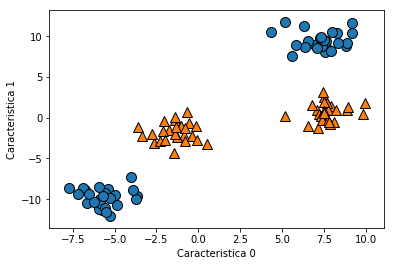

In [3]:
X, y = make_blobs(centers=4, random_state=8)
y = y % 2
dibuja_dispersion_discreta(X[:, 0], X[:, 1], y)
plt.xlabel("Caracteristica 0")
plt.ylabel("Caracteristica 1")

In [5]:
from matplotlib.colors import ListedColormap
cm2 = ListedColormap(['#0000aa', '#ff2020'])

def dibuja_separador_2d(clasificador, X, relleno=False, ax=None, eps=None, alfa=1,
                      cm=cm2, ancholinea=None, umbral=None,
                      estilolinea="solid"):

    if eps is None:
        eps = X.std() / 2.

    if ax is None:
        ax = plt.gca()

    x_min, x_max = X[:, 0].min() - eps, X[:, 0].max() + eps
    y_min, y_max = X[:, 1].min() - eps, X[:, 1].max() + eps
    xx = np.linspace(x_min, x_max, 1000)
    yy = np.linspace(y_min, y_max, 1000)

    X1, X2 = np.meshgrid(xx, yy)
    X_grid = np.c_[X1.ravel(), X2.ravel()]
    try:
        valor_decision = clasificador.decision_function(X_grid)
        niveles = [0] if umbral is None else [umbral]
        niveles_f = [valor_decision.min()] + niveles + [valor_decision.max()]
    except AttributeError:
        # No funciones de decision
        valor_decision = clasificador.predict_proba(X_grid)[:, 1]
        niveles = [.5] if umbral is None else [umbral]
        niveles_f = [0] + niveles + [1]
    if relleno:
        ax.contourf(X1, X2, valor_decision.reshape(X1.shape),
                    levels=niveles_f, alpha=alfa, cmap=cm)
    else:
        ax.contour(X1, X2, valor_decision.reshape(X1.shape), levels=niveles,
                   colors="black", alpha=alfa, linewidths=ancholinea,
                   linestyles=estilolinea, zorder=5)

    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())

Text(0,0.5,'Caracteristica 1')

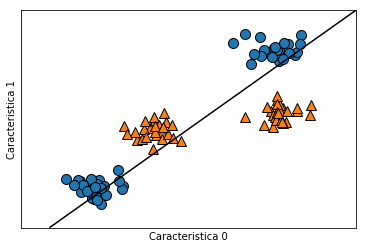

In [6]:
from sklearn.svm import LinearSVC
svm_lineal = LinearSVC().fit(X, y)

dibuja_separador_2d(svm_lineal, X)
dibuja_dispersion_discreta(X[:, 0], X[:, 1], y)
plt.xlabel("Caracteristica 0")
plt.ylabel("Caracteristica 1")

Ahora expandamos el conjunto de características de entrada, por ejemplo agregando `caracteristica1**2`, el cuadrado de la segunda característica, como una nueva característica. En lugar de representar cada punto de datos como un punto bidimensional `(caracteristica0, caracteristica1)`, ahora lo representamos como un punto tridimensional `(caracteristica0, caracteristica1, caracteristica**2)`.

Text(0.5,0,'Caracteristica0**2')

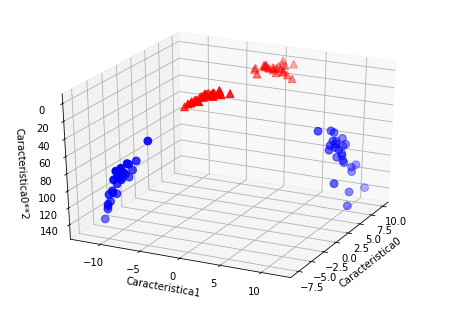

In [7]:
# Agregamos una nueva caracteristica
X_nuevo = np.hstack([X, X[:, 1:] ** 2])
from mpl_toolkits.mplot3d import Axes3D, axes3d
figura = plt.figure()

# visualizamos in 3D
ax = Axes3D(figura, elev=-152, azim=-26)

# dibujamos todos los puntos con y == 0, entonces todos los puntos y == 1
mascara = y == 0
ax.scatter(X_nuevo[mascara, 0], X_nuevo[mascara, 1], X_nuevo[mascara, 2], c='b', cmap=cm2, s=60)
ax.scatter(X_nuevo[~mascara, 0], X_nuevo[~mascara, 1], X_nuevo[~mascara, 2], c='r', marker='^',
           cmap=cm2, s=60)
ax.set_xlabel("Caracteristica0")
ax.set_ylabel("Caracteristica1")
ax.set_zlabel("Caracteristica0**2")

En esta  nueva representación de los datos, ahora es posible separar las dos clases usando un modelo lineal, un plano en tres dimensiones. Podemos confirmar esto ajustando un modelo lineal a los datos aumentados:

Text(0.5,0,'Caracteristica0 ** 2')

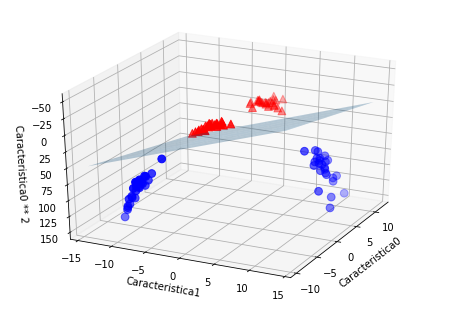

In [8]:
#Ajustamos el modelo
svm_lineal_3d = LinearSVC().fit(X_nuevo, y)
coef, intercept = svm_lineal_3d.coef_.ravel(), svm_lineal_3d.intercept_

# dibujamos la frontera de decision lineal
figura = plt.figure()
ax = Axes3D(figura, elev=-152, azim=-26)
xx = np.linspace(X_nuevo[:, 0].min() - 2, X_nuevo[:, 0].max() + 2, 50)
yy = np.linspace(X_nuevo[:, 1].min() - 2, X_nuevo[:, 1].max() + 2, 50)

XX, YY = np.meshgrid(xx, yy)
ZZ = (coef[0] * XX + coef[1] * YY + intercept) / -coef[2]
ax.plot_surface(XX, YY, ZZ, rstride=8, cstride=8, alpha=0.3)
ax.scatter(X_nuevo[mascara, 0], X_nuevo[mascara, 1], X_nuevo[mascara, 2], c='b', cmap=cm2, s=60)
ax.scatter(X_nuevo[~mascara, 0], X_nuevo[~mascara, 1], X_nuevo[~mascara, 2], c='r', marker='^', cmap=cm2, s=60)

ax.set_xlabel("Caracteristica0")
ax.set_ylabel("Caracteristica1")
ax.set_zlabel("Caracteristica0 ** 2")

Como una función de las características originales, el modelo SVM lineal ya no es realmente lineal. No es una línea, sino más una elipse, como se puede ver en el siguiente gráfico creado aquí:

Text(0,0.5,'Caracteristica 1')

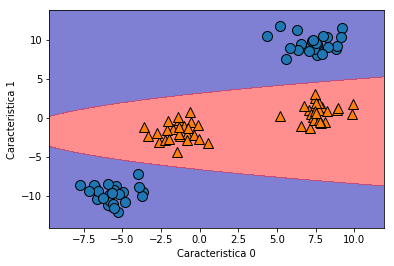

In [9]:
ZZ = YY ** 2
decision = svm_lineal_3d.decision_function(np.c_[XX.ravel(), YY.ravel(), ZZ.ravel()])
plt.contourf(XX, YY, decision.reshape(XX.shape), levels=[decision.min(), 0, decision.max()],
             cmap=cm2, alpha=0.5)
dibuja_dispersion_discreta(X[:, 0], X[:, 1], y)
plt.xlabel("Caracteristica 0")
plt.ylabel("Caracteristica 1")

### Kernel trick

La lección aprendida aquí es que agregar características no lineales a la representación de nuestros datos puede hacer que los modelos lineales sean mucho más potentes. Sin embargo, a menudo no sabemos qué característica agregar  y agregar muchas características (como todas las interacciones posibles en un espacio de características de 100 dimensiones) puede hacer que el cálculo sea muy costoso.

Hay un ingenioso truco matemático que nos permite aprender un clasificador en un espacio de dimensiones superiores sin calcular la nueva representación, posiblemente muy grande. Esto se conoce como `kernel trick`  y funciona calculando directamente la distancia (más precisamente, los productos escalares) de los puntos de datos para la representación de la característica expandida, sin siquiera computar realmente la expansión.

Hay dos maneras de mapear tus datos en un espacio de dimensiones superiores que se usan comúnmente con máquinas de vectores de soporte: el kernel polinomial, que calcula todos los polinomios posibles hasta un cierto grado de las características originales (como `caracteristica1**2 * caracteristica2 ** 5`) y el kernel de la función de base radial (RBF), también conocido como Kernel de Gauss. Una forma de explicar el kernel de Gauss es que considera todos los posibles polinomios de todos los grados, pero la importancia de las características disminuye para los grados superiores.

### Entendiendo SVM

Durante el entrenamiento, el SVM aprende qué tan importante es que cada uno de los puntos de datos de entrenamiento represente la frontera  de decisión entre las dos clases. Normalmente, solo un subconjunto de los puntos de entrenamiento es importante para definir la frontera  decisión: los que se encuentran en el límite entre las clases. Estos se llaman vectores de soporte y le dan su nombre a la máquina de vectores de soporte.

Para hacer una predicción para un nuevo punto, se mide la distancia a cada uno de los vectores de soporte. Una decisión de clasificación se basa en las distancias al vector de soporte y la importancia de los vectores de soporte que se aprendieron durante el entrenamiento (almacenados en el atributo `dual_coef_` de `SVC`).

La distancia entre dos puntos es medida utilizando el [kernel de Gauss](https://en.wikipedia.org/wiki/Radial_basis_function_kernel): $k_{rbf}(x_1, x_2) = \exp(\gamma\Vert x_1 -x_2 \Vert^2)$.

Aquí $\gamma$ es un paramétro que representa el ancho del kernel de Gauss.

In [10]:
def hacer_handcraft():
    # conjunto de datos construidos a mano
    X, y = make_blobs(centers=2, random_state=4, n_samples=30)
    y[np.array([7, 27])] = 0
    mascara = np.ones(len(X), dtype=np.bool)
    mascara[np.array([0, 1, 5, 26])] = 0
    X, y = X[mascara], y[mascara]
    return X, y

Text(0,0.5,'Caracteristica 1')

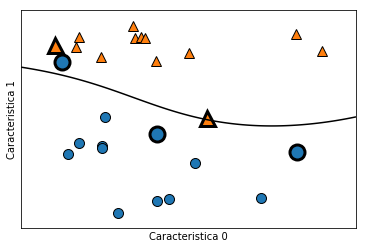

In [13]:
from sklearn.svm import SVC
X, y = hacer_handcraft()
svm = SVC(kernel='rbf', C=10, gamma=0.1).fit(X, y)
dibuja_separador_2d(svm, X, eps=.5)
dibuja_dispersion_discreta(X[:, 0], X[:, 1], y)

# dibujamos vectores de soporte
sv = svm.support_vectors_

# las etiquetas de clase de los vectores de soporte son dadas por el signo de los coeficientes duales
sv_etiquetas = svm.dual_coef_.ravel() > 0
dibuja_dispersion_discreta(sv[:, 0], sv[:, 1], sv_etiquetas, s=15, anchobordemarcador=3)
plt.xlabel("Caracteristica 0")
plt.ylabel("Caracteristica 1")

En este caso, el SVM produce un límite muy suave y no lineal (no una línea recta).

### Ajuste de los parámetros de SVM

El parámetro `gamma` es el que se muestra en la fórmula dada en la sección anterior,  controla el ancho del Kernel gaussiano. Determina la escala de lo que significa que los puntos estén juntos. El parámetro `C` es un parámetro de regularización, similar al utilizado en los modelos lineales. Limita la importancia de cada punto (o más precisamente, su `dual_coef_`).

In [14]:
from sklearn.svm import SVC
def dibuja_svm(log_C, log_gamma, ax=None):
    X, y = hacer_handcraft()
    C = 10. ** log_C
    gamma = 10. ** log_gamma
    svm = SVC(kernel='rbf', C=C, gamma=gamma).fit(X, y)
    if ax is None:
        ax = plt.gca()
    dibuja_separador_2d(svm, X, ax=ax, eps=.5)
    # Dibujamos los datos
    dibuja_dispersion_discreta(X[:, 0], X[:, 1], y, ax=ax)
    # dibujamos los vectores de soporte
    sv = svm.support_vectors_
    # las etiquetas de clase de los vectores de soporte son dadas por el signo de los coeficientes duales
    sv_etiquetas = svm.dual_coef_.ravel() > 0
    dibuja_dispersion_discreta(sv[:, 0], sv[:, 1], sv_etiquetas, s=15, anchobordemarcador=3, ax =ax)
    ax.set_title("C = %.4f gamma = %.4f" % (C, gamma))

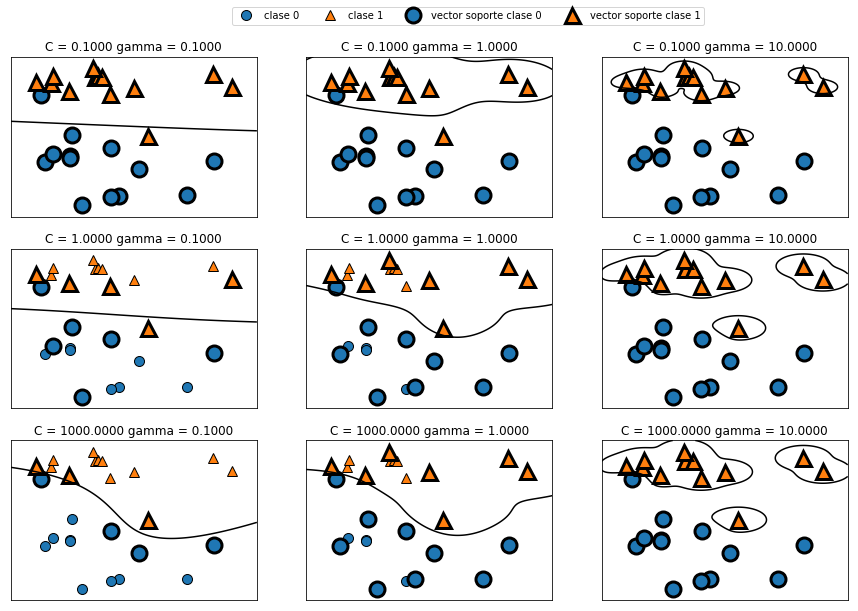

In [15]:
fig, axes = plt.subplots(3, 3, figsize=(15, 10))
for ax, C in zip(axes, [-1, 0, 3]):
    for a, gamma in zip(ax, range(-1, 2)):
        dibuja_svm(log_C=C, log_gamma=gamma, ax=a)
        axes[0, 0].legend(["clase 0", "clase 1", "vector soporte clase 0", "vector soporte clase 1"],
                          ncol=4, loc=(.9, 1.2))

Yendo de izquierda a derecha, aumentamos el valor del parámetro gamma de `0.1` a `10`. Una pequeña gama significa un gran radio para el kernel gaussiano, lo que significa que muchos puntos se consideran cercanos. Esto se refleja en la frontera de decisión muy suaves a la izquierda y en límites que se enfocan más en puntos individuales más hacia la derecha. Un valor bajo de gamma significa que la frontera de decisión variará lentamente, lo que arroja un modelo de baja complejidad, mientras que un valor alto de gamma produce un modelo más complejo.

Yendo de arriba a abajo, aumentamos el parámetro C de `0.1` a `1000`. Al igual que con los modelos lineales, un valor de  C pequeñ significa un modelo muy restringido, donde cada punto de datos solo puede tener una influencia muy limitada. Se puede ver que en la esquina superior izquierda que la frontera  de decisión parece casi lineal y los puntos mal clasificados apenas tienen influencia en la línea. El aumento de C, como se muestra en la parte inferior derecha, permite que estos puntos tengan una mayor influencia en el modelo y hace que la frontera  de decisión se doble para clasificarlos correctamente.

#### Ejemplo 

Apliquemos el RBF al conjunto de datos `Breast Cancer`, con los parámetros `gamma` y `C` por defecto.

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()
X_entrenamiento, X_prueba, y_entrenamiento, y_prueba = train_test_split( cancer.data, cancer.target,random_state=0)

svc =SVC()
svc.fit(X_entrenamiento, y_entrenamiento)
print("Puntuacion del conjunto de entrenamiento: {:.3f}".format(svc.score(X_entrenamiento, y_entrenamiento)))
print("Puntuacion del conjunto de prueba: {:.3f}".format(svc.score(X_prueba, y_prueba)))

Puntuacion del conjunto de entrenamiento: 1.000
Puntuacion del conjunto de prueba: 0.629


El modelo se sobrecarga bastante, con una puntuación perfecta en el conjunto de entrenamiento y solo un 63% de precisión en el conjunto de prueba. Mientras que las SVM suelen funcionar bastante bien, son muy sensibles a la configuración de los parámetros y al escalado de los datos. En particular, requieren que todas las características varíen en una escala similar.

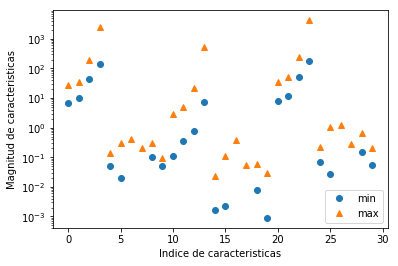

In [17]:
plt.plot(X_entrenamiento.min(axis=0), 'o', label="min")
plt.plot(X_entrenamiento.max(axis=0), '^', label="max")
plt.legend(loc=4)
plt.xlabel("Indice de caracteristicas")
plt.ylabel("Magnitud de caracteristicas")
plt.yscale("log")

A partir de este gráfico, podemos determinar que las características del conjunto de datos `Breast Cancer` son de órdenes de magnitud completamente diferentes. Esto puede ser un problema para otros modelos (como los modelos lineales), pero tiene efectos devastadores para el kernel SVM.

### Procesamiento de datos para SVM

Una forma de resolver este problema es volviendo a escalar cada característica para que todas estén aproximadamente en la misma escala. Un método común de reajuste para los kernels de SVM es escalar los datos de modo que todas las características estén entre 0 y 1. Este trabajo se hace  utilizando el método de preprocesamiento `MinMaxScaler`.

Realicemos este proceso a mano.


In [18]:
# calculamos el minimo valor por caracteristica en el conjunto de entrenamiento
min_en_entrenamiento = X_entrenamiento.min(axis=0)

# calculamos el rango de cada caracteristica de cada caracteristica (max - min) en el conjunto de entrenamiento
rango_en_entrenamiento = (X_entrenamiento - min_en_entrenamiento).max(axis=0)

# sustraemos el min y dividimos por rango
# despues, min=0 y max=1 para cada caracteristica
X_entrenamiento_escalado = (X_entrenamiento - min_en_entrenamiento)/ rango_en_entrenamiento
print("Minimo para cada caracteristica\n{}".format(X_entrenamiento_escalado.min(axis=0)))
print("Maximo para cada caracteristica\n {}".format(X_entrenamiento_escalado.max(axis=0)))

Minimo para cada caracteristica
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
Maximo para cada caracteristica
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.]


Usamos la transformación para el conjunto de pruebas

In [19]:
X_prueba_escalado = (X_prueba - min_en_entrenamiento)/ rango_en_entrenamiento

In [20]:
svc =SVC()
svc.fit(X_entrenamiento_escalado, y_entrenamiento)
print("Puntuacion del conjunto de entrenamiento: {:.3f}".format(svc.score(X_entrenamiento_escalado, y_entrenamiento)))
print("Puntuacion del conjunto de prueba: {:.3f}".format(svc.score(X_prueba_escalado, y_prueba)))

Puntuacion del conjunto de entrenamiento: 0.948
Puntuacion del conjunto de prueba: 0.951


Escalar los datos hizo una gran diferencia.  Ahora estamos en un régimen de subajuste, donde el rendimiento del conjunto de entrenamiento y del conjunto de pruebas son bastante similares, pero con una precisión casi inferior al 100%. A partir de aquí, podemos intentar aumentar C o gamma para adaptar  un modelo más complejo.


In [21]:
svc =SVC(C=1000)
svc.fit(X_entrenamiento_escalado, y_entrenamiento)

print("Puntuacion del conjunto de entrenamiento: {:.3f}".format(svc.score(X_entrenamiento_escalado, y_entrenamiento)))
print("Puntuacion del conjunto de prueba: {:.3f}".format(svc.score(X_prueba_escalado, y_prueba)))

Puntuacion del conjunto de entrenamiento: 0.988
Puntuacion del conjunto de prueba: 0.972


### Fortalezas, debilidades y paramétros

Las máquinas de vectores de soporte con kernel son potentes modelos y funcionan bien en una variedad de conjuntos de datos. Las SVM permiten fronteras de decisión complejas, incluso si los datos tienen solo algunas características. Funcionan bien en datos de baja dimensión y alta dimensión, pero no se escalan muy bien con el número de muestras. Ejecutar un SVM en datos con hasta 10.000 muestras podría funcionar bien, pero trabajar con conjuntos de datos de tamaño 100.000 o más puede ser un desafío en términos de tiempo de ejecución y uso de memoria.

Un SVM  requiere un preprocesamiento cuidadoso de los datos y ajuste de los parámetros. Esta es la razón por la cual, en la actualidad, la mayoría de la gente usa modelos basados en árboles, como bosques aleatorios o gradient boosting (que requieren poco o ningún preprocesamiento) en muchas aplicaciones. Además, los modelos SVM son difíciles de inspeccionar; puede ser difícil entender por qué se hizo una predicción particular y podría ser complicado explicar el modelo a un no experto.

Aún así, podría valer la pena probar las SVM, especialmente si todas tus características representan mediciones en unidades similares (por ejemplo, todas son intensidades de píxeles) y están en similares escalas.

Los parámetros importantes en las SVM con kernel son el parámetro de regularización `C`, la elección del kernel y los parámetros específicos del kernel. Aunque nos centramos principalmente en el kernel `RBF`, hay otras opciones disponibles en scikit-learn.

El kernel RBF tiene solo un parámetro, `gamma`, que es el inverso del ancho del kernel gaussiano. `gamma` y `C` controlan la complejidad del modelo, con valores grandes que dan como resultado un modelo más complejo. Por lo tanto, las buenas configuraciones para los dos parámetros suelen estar fuertemente correlacionadas  y  por tanto `C `y `gamma` deben ajustarse juntos.
